[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/utkarshp1161/Active-learning-in-microscopy/blob/main/notebooks/0_getting_started_BO-GP.ipynb)
# Bayesian Inference with Gaussian Processes: Tutorial

This tutorial demonstrates Bayesian inference with Gaussian Processes (GPs) on a synthetic function composed of two Gaussian peaks. We compare different prior configurations for the GP's hyperparameters and analyze the results both visually and quantitatively.

- Written in Gpytorch and Botorch by [Utkarsh Pratiush](https://github.com/utkarshp1161)

---
**Outline:**
1. Import Required Libraries
2. Define the Ground Truth Function
3. Generate Training Data
4. Configure GP Priors for Bayesian Inference
5. Define the Custom GP Model
6. Run Bayesian Inference for Each Prior
7. Visualize Posterior Inference Results
8. Visualize Learned Hyperparameters
9. Quantitative Analysis of Posterior Quality



## 1. Import Required Libraries

Import all necessary Python libraries for GP modeling, visualization, and data handling. This includes PyTorch, GPyTorch, BoTorch, Matplotlib, NumPy, and Seaborn.

In [ ]:
#install
!pip install -q botorch==0.12.0
!pip install -q gpytorch==1.13


In [1]:
import torch
import gpytorch
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List, Dict
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Define the Ground Truth Function

Implement a function representing the true underlying process: a sum of two Gaussian peaks with a small linear background. This function will be used to generate synthetic data and for evaluation.

In [9]:
def ground_truth_function(x: torch.Tensor) -> torch.Tensor:
    """
    Ground Truth: Two Gaussian peaks function
    Peak 1: centered at 0.3 with width 0.1
    Peak 2: centered at 0.7 with width 0.15, slightly taller
    """
    x = x.to(dtype=torch.float64)
    
    # First Gaussian peak
    peak1 = 2.0 * torch.exp(-((x - 0.3) ** 2) / (2 * 0.1 ** 2))
    
    # Second Gaussian peak (taller and wider)
    peak2 = 2.5 * torch.exp(-((x - 0.7) ** 2) / (2 * 0.15 ** 2))
    
    # Add small background trend
    background = 0.2 * x
    
    return (peak1 + peak2 + background)

## 3. Generate Training Data

Create a function to sample training data from the ground truth, adding configurable Gaussian noise. The data includes both random and strategically placed points near the peaks for better coverage.

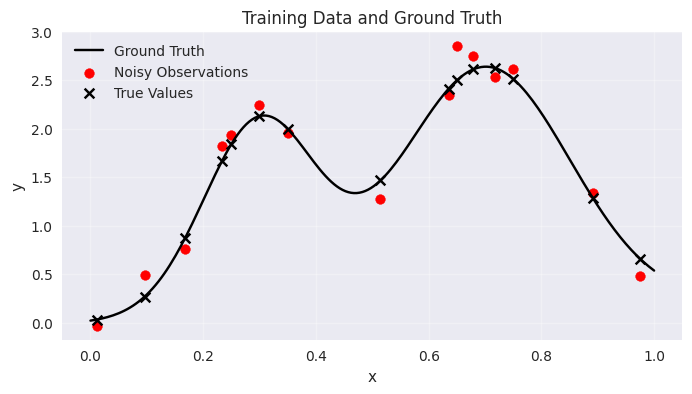

In [ ]:
def generate_training_data(n_points: int = 15, noise_level: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate training data from ground truth with noise"""
    random_points = torch.rand(n_points - 4, dtype=torch.float64)
    strategic_points = torch.tensor([0.25, 0.35, 0.65, 0.75], dtype=torch.float64)  # Near peaks
    
    train_x = torch.cat([random_points, strategic_points]).sort()[0].unsqueeze(-1)
    
    true_y = ground_truth_function(train_x)
    if true_y.ndim == 1:
        true_y = true_y.unsqueeze(-1)
    train_y = true_y + noise_level * torch.randn_like(true_y)
    
    return train_x, train_y, true_y

train_x, train_y, true_y = generate_training_data(n_points=15, noise_level=0.15)

plt.figure(figsize=(8, 4))
test_x = torch.linspace(0, 1, 200, dtype=torch.float64).unsqueeze(-1)
plt.plot(test_x.numpy().squeeze(), ground_truth_function(test_x).numpy().squeeze(), 'k-', label='Ground Truth')
plt.scatter(train_x.numpy(), train_y.numpy(), c='red', label='Noisy Observations')
plt.scatter(train_x.numpy(), true_y.numpy(), c='black', marker='x', label='True Values')
plt.title("Training Data and Ground Truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Configure GP Priors for Bayesian Inference

Define a set of different prior configurations for the GP's lengthscale and noise parameters. This allows us to compare how different prior beliefs affect the inference results.

In [33]:
def get_prior_configurations() -> List[Tuple]:
    """Define different prior configurations for comparison, including cases where the GP will likely miss peaks."""
    configs = [
        (
            gpytorch.priors.GammaPrior(10.0, 2.0),  # Very long lengthscale (mean=5.0)
            gpytorch.priors.GammaPrior(1.0, 20.0),  # Very low noise (mean=0.05)
            "Very-long, Very-low-noise"
        ),
        (
            gpytorch.priors.GammaPrior(0.5, 20.0),  # Very short lengthscale (mean=0.025)
            gpytorch.priors.GammaPrior(5.0, 2.0),   # Very high noise (mean=2.5)
            "Very-short, Very-high-noise"
        ),
        (
            gpytorch.priors.GammaPrior(5.0, 5.0),   # Long lengthscale (mean=1.0)
            gpytorch.priors.GammaPrior(2.0, 2.0),   # Medium-high noise (mean=1.0)
            "Long, Medium-high-noise"
        ),
        (
            gpytorch.priors.GammaPrior(2.0, 10.0),  # Short lengthscale (mean=0.2)
            gpytorch.priors.GammaPrior(1.0, 10.0),  # Low noise (mean=0.1)
            "Short, Low-noise"
        ),
        (
            gpytorch.priors.GammaPrior(3.0, 6.0),   # Medium lengthscale (mean=0.5)
            gpytorch.priors.GammaPrior(1.5, 15.0),  # Medium noise (mean=0.1)
            "Medium-length, Medium-noise"
        ),
        (
            gpytorch.priors.GammaPrior(5.0, 5.0),   # Long lengthscale (mean=1.0)
            gpytorch.priors.GammaPrior(2.0, 5.0),   # High noise (mean=0.4)
            "Long-length, High-noise"
        ),
        (
            None,  # No lengthscale prior
            None,  # No noise prior
            "No Prior (MLE)"
        )
    ]
    return configs

# Show prior configurations
for _, _, name in get_prior_configurations():
    print(f"Configured prior: {name}")

Configured prior: Very-long, Very-low-noise
Configured prior: Very-short, Very-high-noise
Configured prior: Long, Medium-high-noise
Configured prior: Short, Low-noise
Configured prior: Medium-length, Medium-noise
Configured prior: Long-length, High-noise
Configured prior: No Prior (MLE)


## 5. Define the Custom GP Model

Implement a custom GP model class that accepts configurable priors for the kernel lengthscale and noise, using GPyTorch and BoTorch.

In [ ]:
class GPModel(SingleTaskGP):
    """Custom GP model with configurable priors for Bayesian inference"""
    def __init__(self, train_X, train_Y, lengthscale_prior=None, noise_prior=None):
        train_X = train_X.to(dtype=torch.float64)
        train_Y = train_Y.to(dtype=torch.float64)
        
        covar_module = ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior))
        likelihood = GaussianLikelihood(noise_prior=noise_prior)
        
        super().__init__(train_X, train_Y, covar_module=covar_module, likelihood=likelihood)

## 6. Run Bayesian Inference for Each Prior

For each prior configuration, fit a GP model to the training data using Bayesian inference. Store the resulting models for later analysis.

In [ ]:
def run_bayesian_inference(train_x: torch.Tensor, train_y: torch.Tensor, 
                          lengthscale_prior=None, noise_prior=None) -> GPModel:
    """Run Bayesian inference to fit GP model"""
    
    gp = GPModel(
        train_X=train_x,
        train_Y=train_y,
        lengthscale_prior=lengthscale_prior,
        noise_prior=noise_prior
    )
    
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    
    try:
        fit_gpytorch_mll(mll)
    except Exception as e:
        print(f"Fitting failed: {e}, using default parameters")
    
    return gp

prior_configs = get_prior_configurations()
all_gps = {}

for lengthscale_prior, noise_prior, config_name in prior_configs:
    print(f"Fitting GP with prior: {config_name}")
    gp = run_bayesian_inference(train_x, train_y, lengthscale_prior, noise_prior)
    all_gps[config_name] = gp

Fitting GP with prior: Very-long, Very-low-noise


Fitting GP with prior: Very-short, Very-high-noise
Fitting GP with prior: Long, Medium-high-noise
Fitting GP with prior: Short, Low-noise
Fitting GP with prior: Medium-length, Medium-noise
Fitting GP with prior: Long-length, High-noise
Fitting GP with prior: No Prior (MLE)


## 7. Visualize Posterior Inference Results

Plot the GP posterior mean and confidence intervals for each prior configuration, overlaying the ground truth and training data to visually assess model fit.

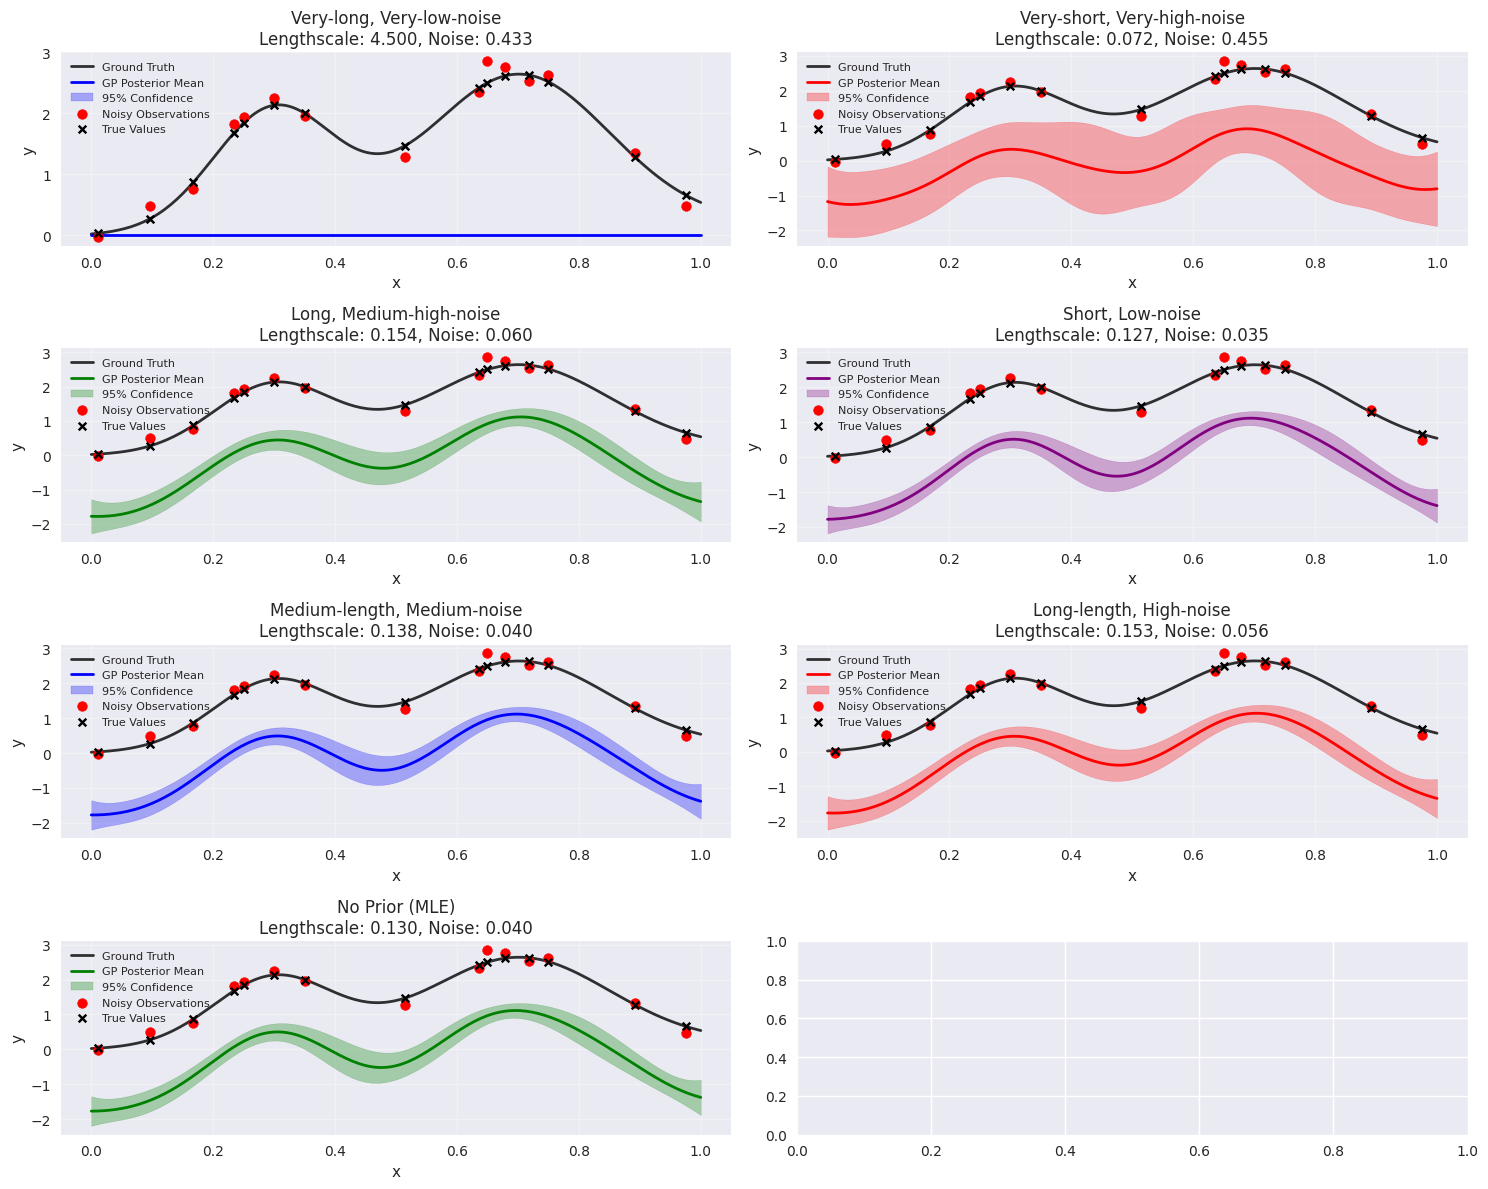

In [ ]:
def plot_posterior_inference(train_x: torch.Tensor, train_y: torch.Tensor, 
                           true_y: torch.Tensor, all_gps: Dict[str, GPModel]):
    """Create comprehensive visualization of Bayesian inference results"""
    
    test_x = torch.linspace(0, 1, 200, dtype=torch.float64).unsqueeze(-1)
    true_test_y = ground_truth_function(test_x)
    
    fig, axes = plt.subplots(4, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    colors = ['blue', 'red', 'green', 'purple']
    
    for idx, (config_name, gp) in enumerate(all_gps.items()):
        ax = axes[idx]
        color = colors[idx % len(colors)]
        
        gp.eval()
        
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            posterior = gp(test_x)
            mean = posterior.mean
            lower, upper = posterior.confidence_region()
        
        ax.plot(test_x.numpy(), true_test_y.numpy(), 'k-', linewidth=2, 
                label='Ground Truth', alpha=0.8)
        
        ax.plot(test_x.numpy(), mean.numpy(), color=color, linewidth=2, 
                label='GP Posterior Mean')
        
        ax.fill_between(test_x.numpy().squeeze(), 
                       lower.numpy(), upper.numpy(),
                       alpha=0.3, color=color, label='95% Confidence')
        
        ax.scatter(train_x.numpy(), train_y.numpy(), 
                  c='red', s=50, zorder=5, label='Noisy Observations')
        ax.scatter(train_x.numpy(), true_y.numpy(), 
                  c='black', s=30, zorder=6, marker='x', label='True Values')
        
        lengthscale = gp.covar_module.base_kernel.lengthscale.item()
        noise = gp.likelihood.noise.item()
        
        ax.set_title(f'{config_name}\nLengthscale: {lengthscale:.3f}, Noise: {noise:.3f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_posterior_inference(train_x, train_y, true_y, all_gps)

## 8. Visualize Learned Hyperparameters

Create bar plots comparing the learned lengthscale and noise parameters across different prior configurations.

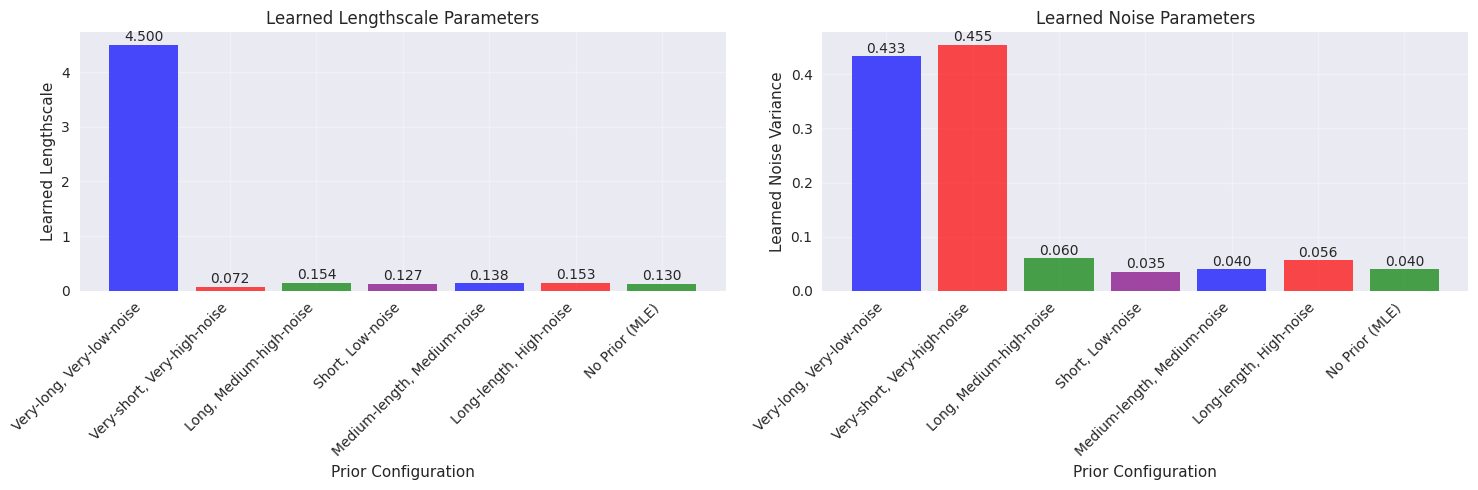

In [ ]:
def plot_hyperparameter_posteriors(all_gps: Dict[str, GPModel]):
    """Visualize learned hyperparameters"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    config_names = list(all_gps.keys())
    lengthscales = [gp.covar_module.base_kernel.lengthscale.item() for gp in all_gps.values()]
    noise_vars = [gp.likelihood.noise.item() for gp in all_gps.values()]
    
    # Lengthscale comparison
    bars1 = ax1.bar(range(len(config_names)), lengthscales, 
                    color=['blue', 'red', 'green', 'purple'], alpha=0.7)
    ax1.set_xlabel('Prior Configuration')
    ax1.set_ylabel('Learned Lengthscale')
    ax1.set_title('Learned Lengthscale Parameters')
    ax1.set_xticks(range(len(config_names)))
    ax1.set_xticklabels(config_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    for bar, val in zip(bars1, lengthscales):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom')
    
    # Noise variance comparison
    bars2 = ax2.bar(range(len(config_names)), noise_vars, 
                    color=['blue', 'red', 'green', 'purple'], alpha=0.7)
    ax2.set_xlabel('Prior Configuration')
    ax2.set_ylabel('Learned Noise Variance')
    ax2.set_title('Learned Noise Parameters')
    ax2.set_xticks(range(len(config_names)))
    ax2.set_xticklabels(config_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    for bar, val in zip(bars2, noise_vars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_hyperparameter_posteriors(all_gps)

## 9. Quantitative Analysis of Posterior Quality

Compute and display quantitative metrics (RMSE, log-likelihood, and coverage probability) for each GP model to objectively compare inference quality.

In [ ]:
def analyze_posterior_quality(all_gps: Dict[str, GPModel], test_x: torch.Tensor):
    """Quantitative analysis of posterior quality"""
    
    true_test_y = ground_truth_function(test_x)
    
    print("Posterior Quality Analysis")
    print("=" * 60)
    print(f"{'Configuration':<25} | {'RMSE':<8} | {'Log-Likelihood':<12} | {'Coverage':<8}")
    print("-" * 60)
    
    for config_name, gp in all_gps.items():
        gp.eval()
        
        with torch.no_grad():
            posterior = gp(test_x)
            mean = posterior.mean
            var = posterior.variance
            lower, upper = posterior.confidence_region()
        
        # Root Mean Square Error
        rmse = torch.sqrt(torch.mean((mean - true_test_y.squeeze()) ** 2)).item()
        
        # Log likelihood (approximate)
        log_likelihood = -0.5 * torch.sum(
            (mean - true_test_y.squeeze()) ** 2 / var + torch.log(2 * np.pi * var)
        ).item()
        
        # Coverage probability (what fraction of true values fall in 95% CI)
        coverage = torch.mean(
            ((true_test_y.squeeze() >= lower) & (true_test_y.squeeze() <= upper)).float()
        ).item()
        
        print(f"{config_name:<25} | {rmse:<8.3f} | {log_likelihood:<12.1f} | {coverage:<8.3f}")

test_x_dense = torch.linspace(0, 1, 100, dtype=torch.float64).unsqueeze(-1)
analyze_posterior_quality(all_gps, test_x_dense)

Posterior Quality Analysis
Configuration             | RMSE     | Log-Likelihood | Coverage
------------------------------------------------------------
Very-long, Very-low-noise | 1.687    | -1189350684.3 | 0.000   
Very-short, Very-high-noise | 1.677    | -709.7       | 0.000   
Long, Medium-high-noise   | 1.683    | -4519.5      | 0.000   
Short, Low-noise          | 1.703    | -6388.2      | 0.000   
Medium-length, Medium-noise | 1.698    | -6088.0      | 0.000   
Long-length, High-noise   | 1.685    | -4769.8      | 0.000   
No Prior (MLE)            | 1.700    | -5839.9      | 0.000   


---

**Summary:**  
This tutorial demonstrated how to perform Bayesian inference with Gaussian Processes on a synthetic two-Gaussian-peaks function. We compared the effects of different prior configurations on the GP's predictions and hyperparameters, and quantitatively assessed model quality using RMSE, log-likelihood, and coverage probability.

Feel free to experiment with the prior settings, noise levels, and training data to further explore Bayesian GP inference!